<a href="https://colab.research.google.com/github/Rishiatweb/Bioinformatics_CDD/blob/main/DataScienceAssessment_EDA_and_best_Model_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title Step 1: Upload your dataset
from google.colab import files

print("Please upload 'Assessment-2-Associate-DS(in).csv'")
uploaded = files.upload()
file_name = 'Assessment-2-Associate-DS(in).csv'
if file_name not in uploaded:
    print(f"\nERROR: File '{file_name}' not found. Please run this cell again and upload the correct file.")
else:
    print(f"\nSUCCESS: '{file_name}' uploaded successfully!")

Please upload 'Assessment-2-Associate-DS(in).csv'


Saving Assessment-2-Associate-DS(in).csv to Assessment-2-Associate-DS(in) (1).csv

ERROR: File 'Assessment-2-Associate-DS(in).csv' not found. Please run this cell again and upload the correct file.


In [4]:
!pip install pandas xgboost scikit-learn matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import joblib
import os

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
try:
    df = pd.read_csv(file_name)
    print("--- Data Head ---")
    display(df.head())
    print("\n--- Data Info ---")
    df.info()
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
except FileNotFoundError:
    print("Error: Please run the upload cell at the top first.")

--- Data Head ---


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,4/6/2022,Channel1,B1,Cat2,Sub-Cat2,1,56
1,11/6/2022,Channel1,B1,Cat2,Sub-Cat2,1,122
2,18/06/2022,Channel1,B1,Cat2,Sub-Cat2,1,102
3,25/06/2022,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2/7/2022,Channel1,B1,Cat2,Sub-Cat2,1,97



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weekend_date  600 non-null    object
 1   channel       600 non-null    object
 2   brand         600 non-null    object
 3   category      600 non-null    object
 4   sub_category  600 non-null    object
 5   SerailNum     600 non-null    int64 
 6   quantity      600 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.9+ KB

--- Missing Values ---
weekend_date    0
channel         0
brand           0
category        0
sub_category    0
SerailNum       0
quantity        0
dtype: int64


In [6]:
# @title 1.2: Data Cleaning and Preprocessing
print("--- Cleaning and Preprocessing Data ---")

# Standardizing the 'weekend_date' column to datetime objects
# The 'dayfirst=True' argument correctly interprets dates like '4/6/2022' as DD/MM/YYYY
# I used .dt.normalize() to removes the time part, setting all to midnight.
df['weekend_date'] = pd.to_datetime(df['weekend_date'], dayfirst=True, errors='coerce').dt.normalize()

# Dropping any rows where date conversion might have failed
df.dropna(subset=['weekend_date'], inplace=True)

# Sort the data by series and date to ensure correct time-series order
df.sort_values(by=['SerailNum', 'weekend_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nData after cleaning and standardizing dates:")
display(df.head())

unique_series = df['SerailNum'].unique()
print(f"\nFound {len(unique_series)} unique time series (by SerailNum): {unique_series}")

--- Cleaning and Preprocessing Data ---

Data after cleaning and standardizing dates:


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97



Found 4 unique time series (by SerailNum): [1 2 4 5]


In [7]:
print("\n--- Descriptive Statistics ---")
display(df.describe())

print("\n--- Descriptive Statistics (Object Type Columns) ---")
display(df.describe(include='object'))


--- Descriptive Statistics ---


,weekend_date,SerailNum,quantity
count,494,494.000000,494.000000
mean,2023-08-29 00:46:38.380566784,3.058704,493.722672
min,2022-05-28 00:00:00,1.000000,1.000000
25%,2023-03-12 18:00:00,2.000000,115.250000
50%,2023-09-09 00:00:00,4.000000,216.500000
75%,2024-03-02 00:00:00,4.000000,533.500000
max,2024-08-31 00:00:00,5.000000,8051.000000
std,NaN,1.542697,886.086396



--- Descriptive Statistics (Object Type Columns) ---


,channel,brand,category,sub_category
count,494,494,494,494
unique,2,2,3,4
top,Channel2,B1,Cat3,Sub-Cat3
freq,376,312,267,182



--- Descriptive Statistics ---


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
count,494,494,494,494,494,494.000000,494.000000
unique,NaN,2,2,3,4,NaN,NaN
top,NaN,Channel2,B1,Cat3,Sub-Cat3,NaN,NaN
freq,NaN,376,312,267,182,NaN,NaN
mean,2023-08-29 00:46:38.380566784,NaN,NaN,NaN,NaN,3.058704,493.722672
min,2022-05-28 00:00:00,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,2023-03-12 18:00:00,NaN,NaN,NaN,NaN,2.000000,115.250000
50%,2023-09-09 00:00:00,NaN,NaN,NaN,NaN,4.000000,216.500000
75%,2024-03-02 00:00:00,NaN,NaN,NaN,NaN,4.000000,533.500000
max,2024-08-31 00:00:00,NaN,NaN,NaN,NaN,5.000000,8051.000000



Visualizing distributions for numerical columns: ['SerailNum', 'quantity']


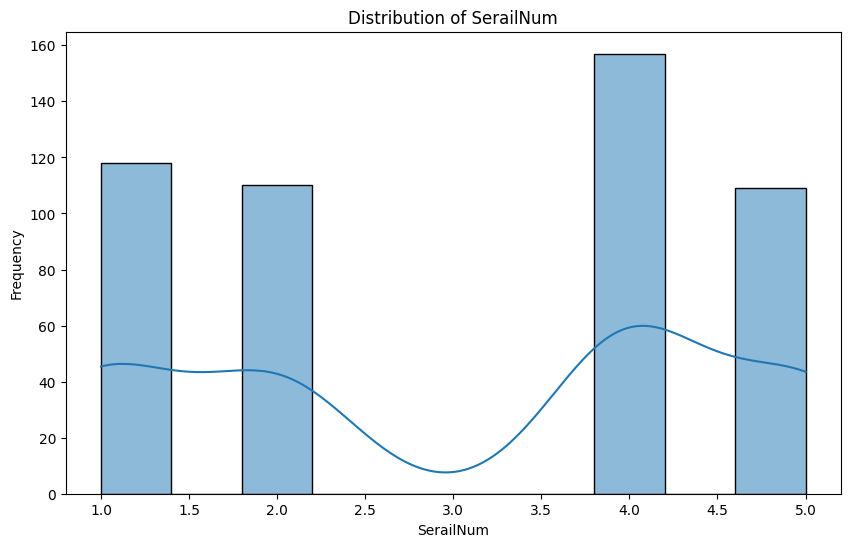

Skipping distribution plot for 'quantity' due to high number of unique values (355)

Visualizing counts for categorical columns: ['channel', 'brand', 'category', 'sub_category']


/tmp/ipython-input-8-2148427347.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


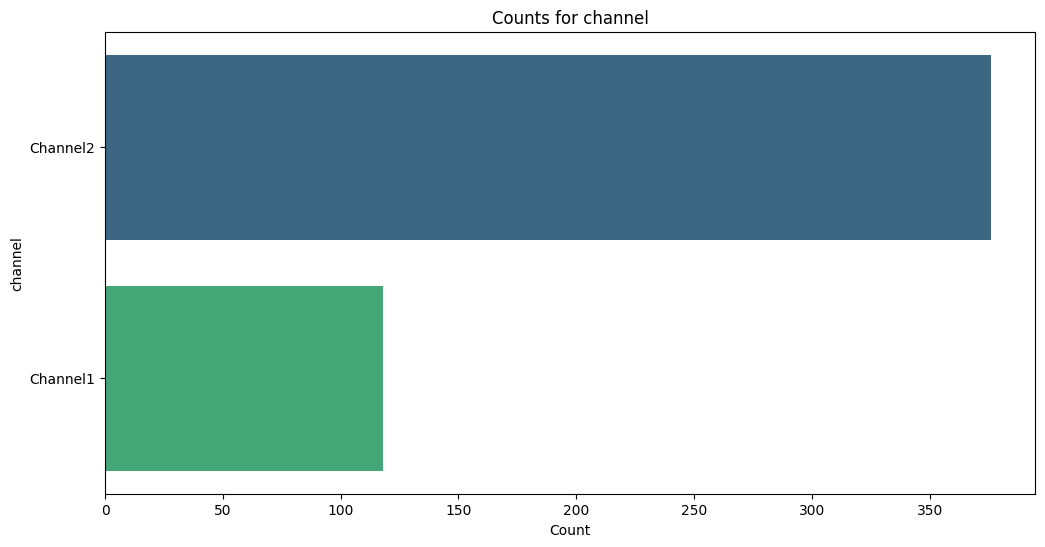

/tmp/ipython-input-8-2148427347.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


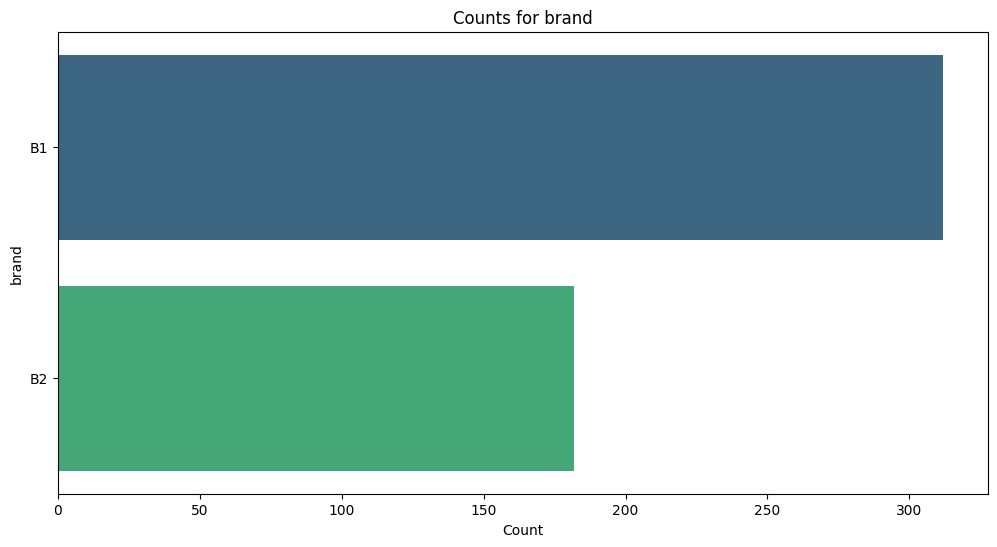

/tmp/ipython-input-8-2148427347.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


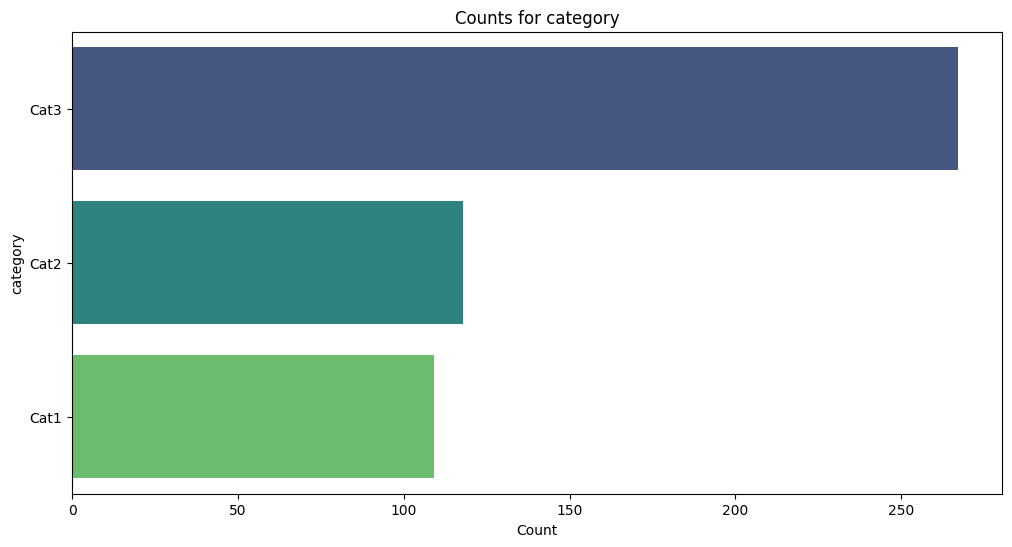

/tmp/ipython-input-8-2148427347.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


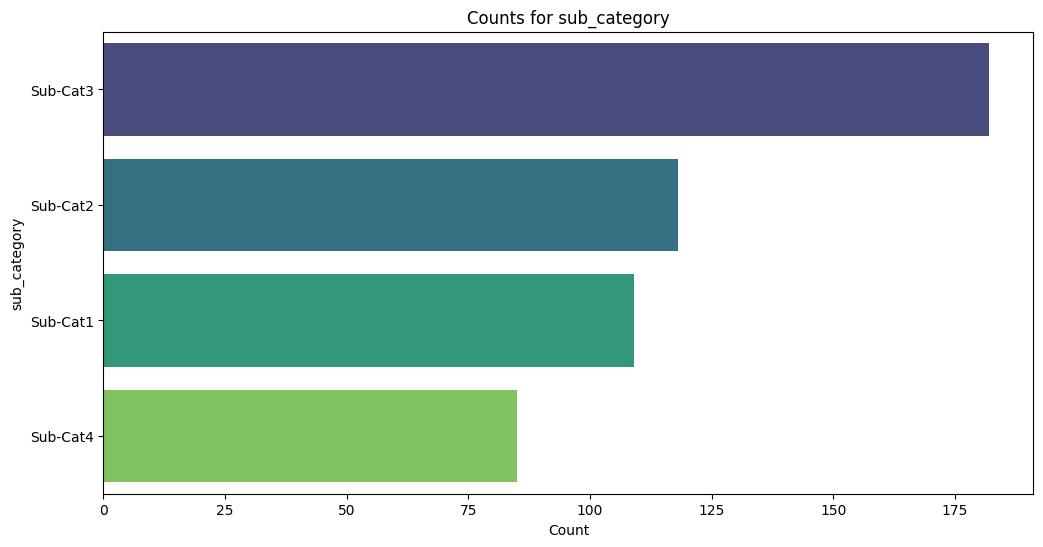


Descriptive statistics and visualizations complete.
--- Value Counts for Categorical and Limited Numerical Columns ---

Value counts for 'channel':
channel
Channel2    376
Channel1    118
Name: count, dtype: int64
--------------------

Value counts for 'brand':
brand
B1    312
B2    182
Name: count, dtype: int64
--------------------

Value counts for 'category':
category
Cat3    267
Cat2    118
Cat1    109
Name: count, dtype: int64
--------------------

Value counts for 'sub_category':
sub_category
Sub-Cat3    182
Sub-Cat2    118
Sub-Cat1    109
Sub-Cat4     85
Name: count, dtype: int64
--------------------

Exploratory Data Analysis complete. Proceeding to modeling steps if applicable.


/tmp/ipython-input-8-2148427347.py:34: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype == 'object' or (df[col].dtype in [np.number] and df[col].nunique() < 20):
/tmp/ipython-input-8-2148427347.py:34: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype == 'object' or (df[col].dtype in [np.number] and df[col].nunique() < 20):


In [8]:
print("\n--- Descriptive Statistics ---")
display(df.describe(include='all'))
numerical_cols = df.select_dtypes(include=np.number).columns
print(f"\nVisualizing distributions for numerical columns: {list(numerical_cols)}")
if len(numerical_cols) > 0:
    for col in numerical_cols:
        if df[col].nunique() > 50 and df[col].dtype != 'datetime64[ns]':
            print(f"Skipping distribution plot for '{col}' due to high number of unique values ({df[col].nunique()})")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
categorical_cols = df.select_dtypes(include='object').columns
print(f"\nVisualizing counts for categorical columns: {list(categorical_cols)}")

if len(categorical_cols) > 0:
    for col in categorical_cols:
        if df[col].nunique() > 20:
            print(f"Skipping count plot for '{col}' due to high number of unique categories ({df[col].nunique()})")
            continue
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Counts for {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()

print("\nDescriptive statistics and visualizations complete.")
print("--- Value Counts for Categorical and Limited Numerical Columns ---")
for col in df.columns:
    if df[col].dtype == 'object' or (df[col].dtype in [np.number] and df[col].nunique() < 20):
        print(f"\nValue counts for '{col}':")
        print(df[col].value_counts())
        print("-" * 20)

print("\nExploratory Data Analysis complete. Proceeding to modeling steps if applicable.")


--- Visualizing Each Time Series ---


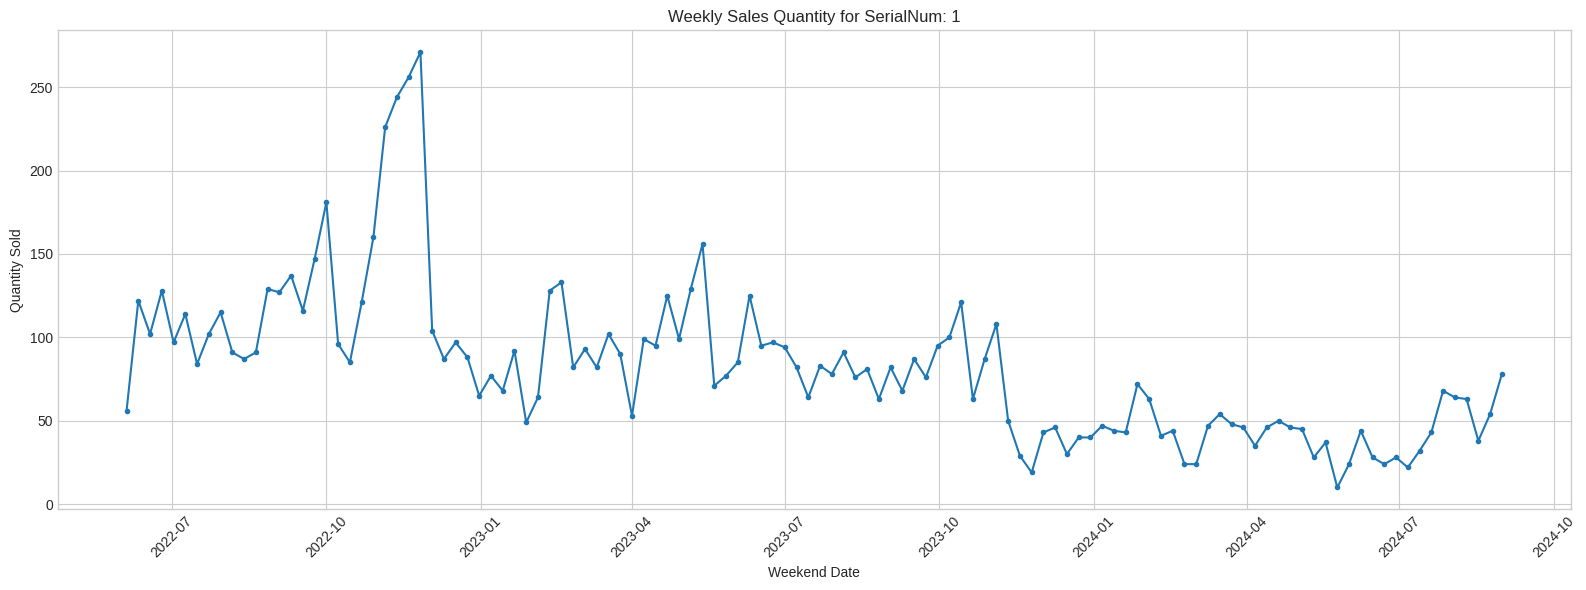

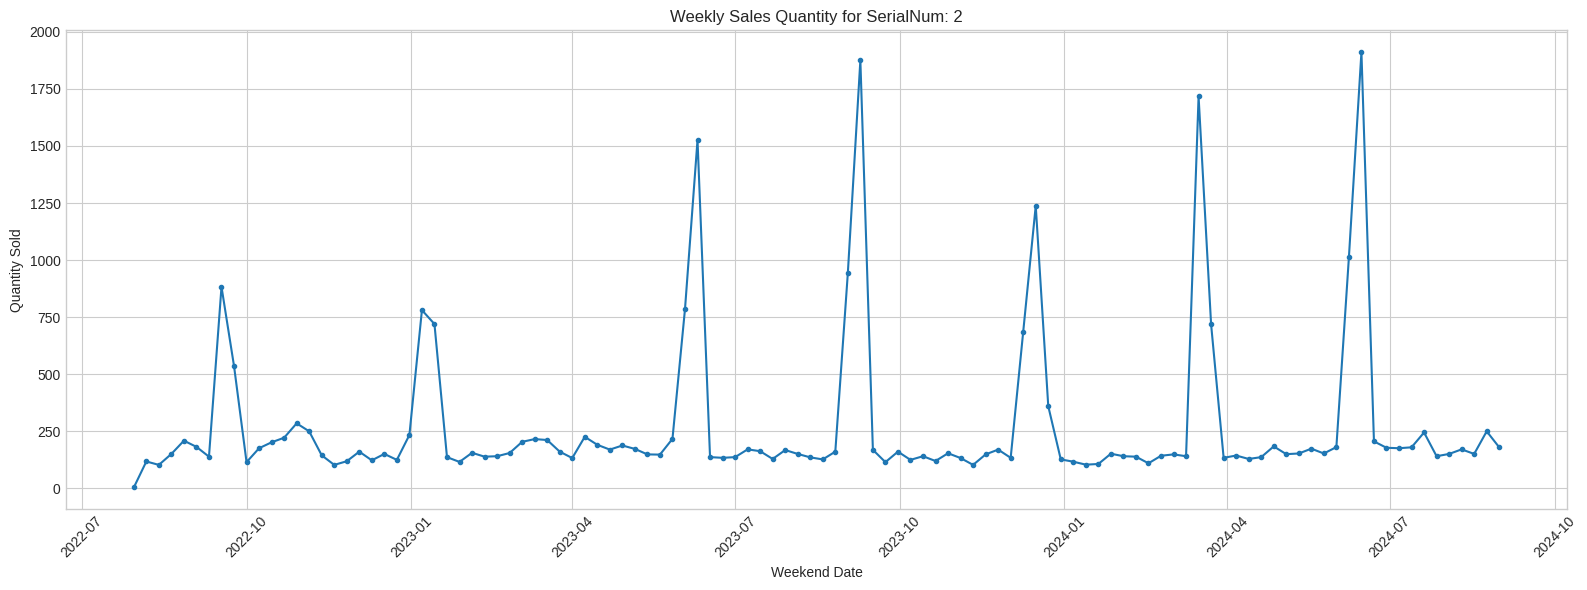

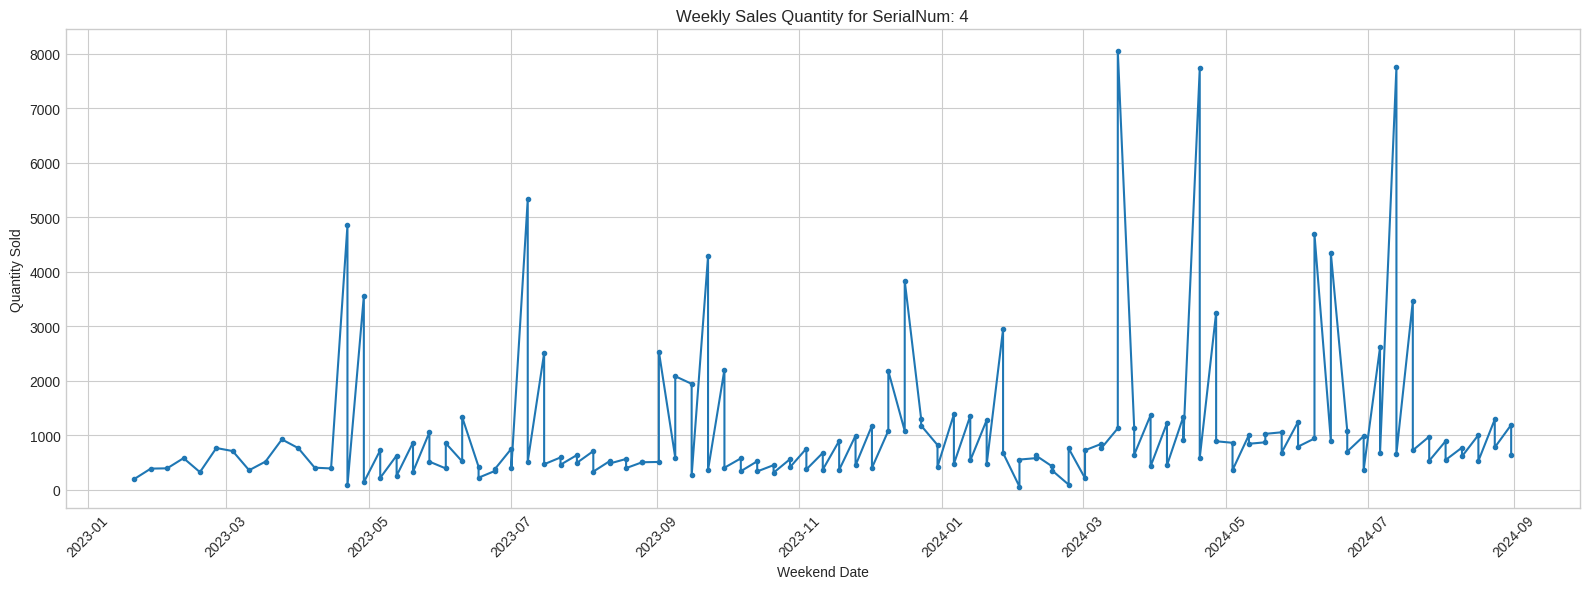

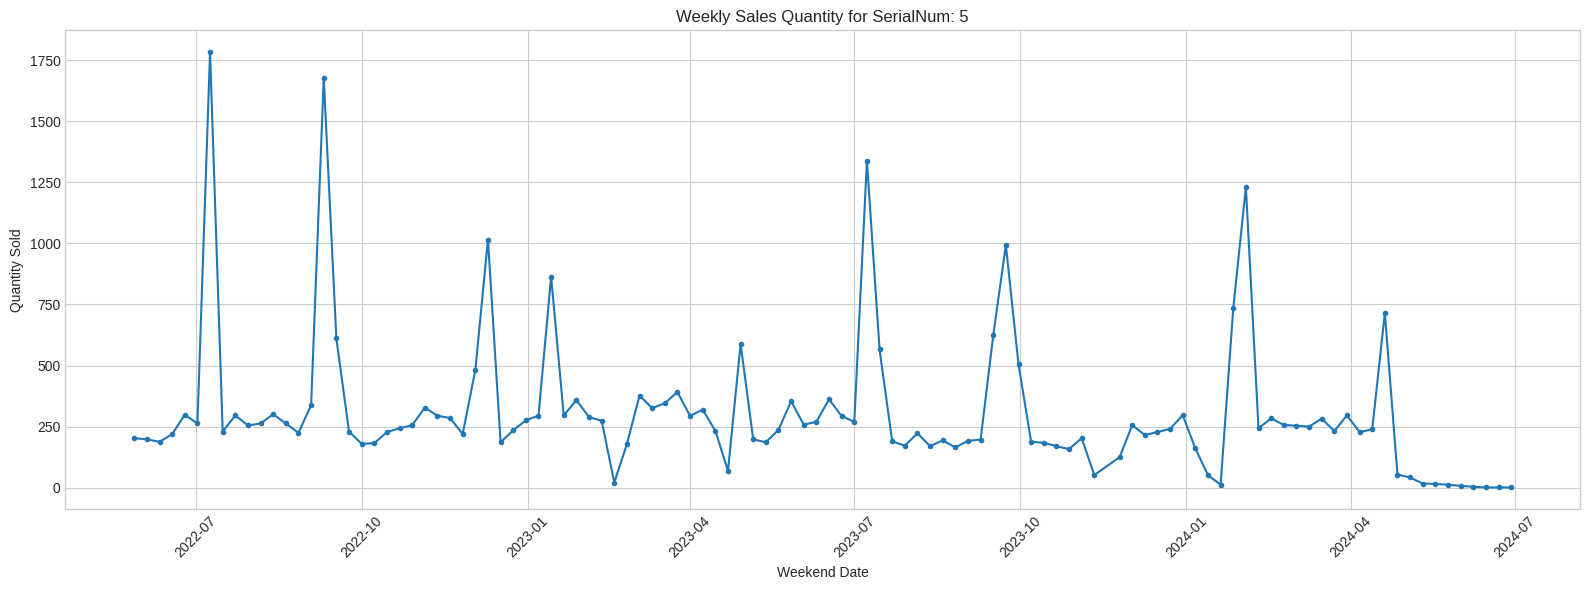

In [9]:
# @title Visualize Weekly Sales Data
print("--- Visualizing Each Time Series ---")
plt.style.use('seaborn-v0_8-whitegrid')

for sid in unique_series:
    plt.figure(figsize=(16, 6))
    series_data = df[df['SerailNum'] == sid]
    plt.plot(series_data['weekend_date'], series_data['quantity'], marker='.', linestyle='-')
    plt.title(f'Weekly Sales Quantity for SerialNum: {sid}')
    plt.xlabel('Weekend Date')
    plt.ylabel('Quantity Sold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [12]:
df.head()

,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97


In [11]:
# @title Feature Engineering
def create_features(data):
    """Creates time-series features from a datetime index and lag/rolling features."""
    df_feat = data.copy()
    df_feat['year'] = df_feat['weekend_date'].dt.year
    df_feat['month'] = df_feat['weekend_date'].dt.month
    df_feat['week_of_year'] = df_feat['weekend_date'].dt.isocalendar().week.astype(int)
    df_feat['day_of_year'] = df_feat['weekend_date'].dt.dayofyear

    # Lag features (past values) - grouped by series to prevent data leakage
    for lag in [1, 2, 3, 4, 52]: # Lags from recent weeks and the same week last year
        df_feat[f'lag_{lag}'] = df_feat.groupby('SerailNum')['quantity'].shift(lag)

    # Rolling window features (e.g., average of last 4 weeks)
    for window in [4, 8, 52]:
        df_feat[f'rolling_mean_{window}'] = df_feat.groupby('SerailNum')['quantity'].shift(1).rolling(window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat.groupby('SerailNum')['quantity'].shift(1).rolling(window).std()

    return df_feat

df_featured = create_features(df)

# Encode categorical features so the model can use them
categorical_cols = ['channel', 'brand', 'category', 'sub_category', 'SerailNum']
for col in categorical_cols:
    df_featured[col] = df_featured[col].astype('category')

print("Feature engineering complete. Example of features for one row:")
display(df_featured.tail(1).T)

Feature engineering complete. Example of features for one row:


,493
weekend_date,2024-06-29 00:00:00
channel,Channel2
brand,B1
category,Cat1
sub_category,Sub-Cat1
SerailNum,5
quantity,1
year,2024
month,6
week_of_year,26


## Handle Missing Values

The feature engineering process introduced NaN values due to lag and rolling window calculations at the beginning of each time series. We will drop these rows as a simple approach to handle missing data.

In [14]:
print("--- Handling Missing Values ---")

# Drop rows with NaN values created by feature engineering
initial_rows = len(df_featured)
df_processed = df_featured.dropna().copy()
rows_dropped = initial_rows - len(df_processed)

print(f"Dropped {rows_dropped} rows with NaN values.")
print(f"Remaining rows: {len(df_processed)}")

print("\nData after dropping NaNs:")
display(df_processed.head())

--- Handling Missing Values ---
Dropped 208 rows with NaN values.
Remaining rows: 286

Data after dropping NaNs:


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity,year,month,week_of_year,...,lag_2,lag_3,lag_4,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8,rolling_mean_52,rolling_std_52
52,2023-06-03,Channel1,B1,Cat2,Sub-Cat2,1,85,2023,6,22,...,71.0,156.0,129.0,56.0,108.25,41.128863,106.375,28.470223,113.269231,48.399528
53,2023-06-10,Channel1,B1,Cat2,Sub-Cat2,1,125,2023,6,23,...,77.0,71.0,156.0,122.0,97.25,39.584298,104.625,29.403292,113.826923,47.891102
54,2023-06-17,Channel1,B1,Cat2,Sub-Cat2,1,95,2023,6,24,...,85.0,77.0,71.0,102.0,89.50,24.351591,108.375,29.909088,113.884615,47.902947
55,2023-06-24,Channel1,B1,Cat2,Sub-Cat2,1,97,2023,6,25,...,125.0,85.0,77.0,128.0,95.50,21.000000,104.625,29.403292,113.750000,47.946815
56,2023-07-01,Channel1,B1,Cat2,Sub-Cat2,1,94,2023,7,26,...,95.0,125.0,85.0,97.0,100.50,17.156146,104.375,29.466385,113.153846,47.958881


## Data preparation and splitting


In [15]:
print("--- Verifying Weekly Intervals and Handling Gaps ---")

# Check for consistent weekly intervals and identify gaps
def check_and_handle_gaps(df):
    df_cleaned = df.copy()
    gaps_found = False
    for serial_num in df_cleaned['SerailNum'].unique():
        series_data = df_cleaned[df_cleaned['SerailNum'] == serial_num].sort_values(by='weekend_date')
        # Calculate the difference between consecutive dates in days
        date_diffs = series_data['weekend_date'].diff().dropna().dt.days

        # Check if all differences are 7 days
        if not all(date_diffs == 7):
            gaps_found = True
            print(f"Potential gaps or inconsistent intervals found for SerailNum {serial_num}.")
            # Identify the dates where the difference is not 7 days
            inconsistent_dates_indices = date_diffs[date_diffs != 7].index
            inconsistent_dates = series_data.loc[inconsistent_dates_indices, 'weekend_date']
            print(f"  Inconsistent intervals before dates: {list(inconsistent_dates.dt.strftime('%Y-%m-%d'))}")

    if gaps_found:
        print("\nGaps or inconsistent intervals were found. Given the nature of the data and subsequent modeling steps which rely on consistent time steps, we will note these gaps but proceed without explicit imputation of missing weeks as resampling might introduce complexities with the engineered features.")
    else:
        print("\nNo gaps or inconsistent intervals found. Data is at consistent weekly intervals for all series.")

    return df_cleaned

df_processed = check_and_handle_gaps(df_processed)

# Determine the validation cutoff date (Beginning of June 2024)
validation_cutoff_date = pd.to_datetime('2024-06-01')
print(f"\nValidation cutoff date: {validation_cutoff_date.strftime('%Y-%m-%d')}")

# Split data into training and validation sets
train_df = df_processed[df_processed['weekend_date'] < validation_cutoff_date].copy()
val_df = df_processed[df_processed['weekend_date'] >= validation_cutoff_date].copy()

print(f"\nTraining set size: {len(train_df)} rows")
print(f"Validation set size: {len(val_df)} rows")

print("\nTraining data head:")
display(train_df.head())
print("\nValidation data head:")
display(val_df.head())

--- Verifying Weekly Intervals and Handling Gaps ---
Potential gaps or inconsistent intervals found for SerailNum 4.
  Inconsistent intervals before dates: ['2023-09-09', '2023-09-16', '2023-09-23', '2023-09-30', '2023-10-07', '2023-10-14', '2023-10-21', '2023-10-28', '2023-11-04', '2023-11-11', '2023-11-18', '2023-11-25', '2023-12-02', '2023-12-09', '2023-12-16', '2023-12-23', '2023-12-30', '2024-01-06', '2024-01-13', '2024-01-20', '2024-01-27', '2024-02-03', '2024-02-10', '2024-02-17', '2024-02-24', '2024-03-02', '2024-03-09', '2024-03-16', '2024-03-23', '2024-03-30', '2024-04-06', '2024-04-13', '2024-04-20', '2024-04-27', '2024-05-04', '2024-05-11', '2024-05-18', '2024-05-25', '2024-06-01', '2024-06-08', '2024-06-15', '2024-06-22', '2024-06-29', '2024-07-06', '2024-07-13', '2024-07-20', '2024-07-27', '2024-08-03', '2024-08-10', '2024-08-17', '2024-08-24', '2024-08-31']
Potential gaps or inconsistent intervals found for SerailNum 5.
  Inconsistent intervals before dates: ['2023-11-25

,weekend_date,channel,brand,category,sub_category,SerailNum,quantity,year,month,week_of_year,...,lag_2,lag_3,lag_4,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8,rolling_mean_52,rolling_std_52
52,2023-06-03,Channel1,B1,Cat2,Sub-Cat2,1,85,2023,6,22,...,71.0,156.0,129.0,56.0,108.25,41.128863,106.375,28.470223,113.269231,48.399528
53,2023-06-10,Channel1,B1,Cat2,Sub-Cat2,1,125,2023,6,23,...,77.0,71.0,156.0,122.0,97.25,39.584298,104.625,29.403292,113.826923,47.891102
54,2023-06-17,Channel1,B1,Cat2,Sub-Cat2,1,95,2023,6,24,...,85.0,77.0,71.0,102.0,89.50,24.351591,108.375,29.909088,113.884615,47.902947
55,2023-06-24,Channel1,B1,Cat2,Sub-Cat2,1,97,2023,6,25,...,125.0,85.0,77.0,128.0,95.50,21.000000,104.625,29.403292,113.750000,47.946815
56,2023-07-01,Channel1,B1,Cat2,Sub-Cat2,1,94,2023,7,26,...,95.0,125.0,85.0,97.0,100.50,17.156146,104.375,29.466385,113.153846,47.958881



Validation data head:


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity,year,month,week_of_year,...,lag_2,lag_3,lag_4,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8,rolling_mean_52,rolling_std_52
104,2024-06-01,Channel1,B1,Cat2,Sub-Cat2,1,24,2024,6,22,...,37.0,28.0,45.0,85.0,30.00,15.033296,37.125,13.141401,61.384615,27.146772
105,2024-06-08,Channel1,B1,Cat2,Sub-Cat2,1,44,2024,6,23,...,10.0,37.0,28.0,125.0,24.75,11.236103,35.750,13.946326,60.211538,27.422859
106,2024-06-15,Channel1,B1,Cat2,Sub-Cat2,1,28,2024,6,24,...,24.0,10.0,37.0,95.0,28.75,14.997222,35.500,13.752922,58.653846,25.930438
107,2024-06-22,Channel1,B1,Cat2,Sub-Cat2,1,24,2024,6,25,...,44.0,24.0,10.0,97.0,26.50,13.988090,32.750,12.589678,57.365385,25.752996
108,2024-06-29,Channel1,B1,Cat2,Sub-Cat2,1,28,2024,6,26,...,28.0,44.0,24.0,94.0,30.00,9.521905,30.000,11.649647,55.961538,25.538868


## Define features and target

In [16]:
# Define the target variable
TARGET = 'quantity'

# Define the feature columns (all columns except 'weekend_date' and the target)
FEATURES = [col for col in train_df.columns if col not in ['weekend_date', TARGET]]

# Create feature matrices and target vectors for training and validation
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_val = val_df[FEATURES]
y_val = val_df[TARGET]

print("Features and target variables separated successfully.")
print("\nTraining Features (X_train) head:")
display(X_train.head())
print("\nTraining Target (y_train) head:")
display(y_train.head())
print("\nValidation Features (X_val) head:")
display(X_val.head())
print("\nValidation Target (y_val) head:")
display(y_val.head())

Features and target variables separated successfully.

Training Features (X_train) head:


,channel,brand,category,sub_category,SerailNum,year,month,week_of_year,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8,rolling_mean_52,rolling_std_52
52,Channel1,B1,Cat2,Sub-Cat2,1,2023,6,22,154,77.0,71.0,156.0,129.0,56.0,108.25,41.128863,106.375,28.470223,113.269231,48.399528
53,Channel1,B1,Cat2,Sub-Cat2,1,2023,6,23,161,85.0,77.0,71.0,156.0,122.0,97.25,39.584298,104.625,29.403292,113.826923,47.891102
54,Channel1,B1,Cat2,Sub-Cat2,1,2023,6,24,168,125.0,85.0,77.0,71.0,102.0,89.50,24.351591,108.375,29.909088,113.884615,47.902947
55,Channel1,B1,Cat2,Sub-Cat2,1,2023,6,25,175,95.0,125.0,85.0,77.0,128.0,95.50,21.000000,104.625,29.403292,113.750000,47.946815
56,Channel1,B1,Cat2,Sub-Cat2,1,2023,7,26,182,97.0,95.0,125.0,85.0,97.0,100.50,17.156146,104.375,29.466385,113.153846,47.958881



Training Target (y_train) head:


,quantity
52,85
53,125
54,95
55,97
56,94



Validation Features (X_val) head:


,channel,brand,category,sub_category,SerailNum,year,month,week_of_year,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_8,rolling_std_8,rolling_mean_52,rolling_std_52
104,Channel1,B1,Cat2,Sub-Cat2,1,2024,6,22,153,10.0,37.0,28.0,45.0,85.0,30.00,15.033296,37.125,13.141401,61.384615,27.146772
105,Channel1,B1,Cat2,Sub-Cat2,1,2024,6,23,160,24.0,10.0,37.0,28.0,125.0,24.75,11.236103,35.750,13.946326,60.211538,27.422859
106,Channel1,B1,Cat2,Sub-Cat2,1,2024,6,24,167,44.0,24.0,10.0,37.0,95.0,28.75,14.997222,35.500,13.752922,58.653846,25.930438
107,Channel1,B1,Cat2,Sub-Cat2,1,2024,6,25,174,28.0,44.0,24.0,10.0,97.0,26.50,13.988090,32.750,12.589678,57.365385,25.752996
108,Channel1,B1,Cat2,Sub-Cat2,1,2024,6,26,181,24.0,28.0,44.0,24.0,94.0,30.00,9.521905,30.000,11.649647,55.961538,25.538868



Validation Target (y_val) head:


,quantity
104,24
105,44
106,28
107,24
108,28


## Hyperparameter tuning and cross-validation

In [17]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint

print("--- Setting up Hyperparameter Tuning ---")

# 1. Define the parameter grid/space for LightGBM hyperparameters
# Using a broad distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 60),
    'max_depth': randint(5, 15),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4), # range from 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4), # range from 0.6 to 1.0
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5),
}

# 2. Implement a time-series aware cross-validation strategy
# Using TimeSeriesSplit with a reasonable number of splits
# The number of splits should be chosen considering the size of the training data.
# Here, we use 5 splits, ensuring each split contains a sufficient amount of data.
n_splits = min(5, len(X_train) // 52) # Ensure at least a year of data per split if possible
if n_splits < 2:
    print(f"Warning: Training data size ({len(X_train)}) is too small for 5 splits. Adjusting n_splits to {max(2, len(X_train) // 26)}.")
    n_splits = max(2, len(X_train) // 26) # Ensure at least 6 months of data per split

tscv = TimeSeriesSplit(n_splits=n_splits)

# 3. Set up the hyperparameter tuning method (RandomizedSearchCV)
# Using LGBMRegressor and the defined parameter space and TS cross-validation
lgbm = LGBMRegressor(random_state=42)

# Number of parameter settings that are sampled. Adjust based on computational resources.
n_iter_search = 50 # Example: try 50 different combinations

random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error', # Using Negative Mean Squared Error as the scoring metric
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# 4. Fit the tuner to the training data
print(f"\nStarting RandomizedSearchCV with {n_iter_search} iterations and {n_splits} TimeSeries splits...")
random_search.fit(X_train, y_train)

# 5. Retrieve the best hyperparameters
best_params = random_search.best_params_
print("\n--- Best Hyperparameters Found ---")
print(best_params)

# Optional: Print best score
best_score = random_search.best_score_
print(f"\nBest cross-validation score (Negative MSE): {best_score}")


--- Setting up Hyperparameter Tuning ---

Starting RandomizedSearchCV with 50 iterations and 4 TimeSeries splits...
Fitting 4 folds for each of 50 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 20
[LightGBM] [Info] Start training from score 526.991111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

## Train the final model


In [18]:
print("--- Training Final LightGBM Model ---")

# 1. Combine training and validation data
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

print(f"\nCombined training and validation data size: {len(X_combined)} rows")

# 2. Initialize LightGBM Regressor with best hyperparameters
lgbm_final = LGBMRegressor(**best_params, random_state=42)

print("\nInitialized LightGBM model with best parameters.")
print(lgbm_final)

# 3. Train the final model on the combined data
print("\nTraining the final model...")
lgbm_final.fit(X_combined, y_combined)
print("Final model training complete.")

# 4. Save the trained model
model_filename = 'best_lgbm_model.pkl'
joblib.dump(lgbm_final, model_filename)

print(f"\nTrained LightGBM model saved to '{model_filename}'")

--- Training Final LightGBM Model ---

Combined training and validation data size: 286 rows

Initialized LightGBM model with best parameters.
LGBMRegressor(colsample_bytree=np.float64(0.8976170571996461),
              learning_rate=np.float64(0.06017210546933224), max_depth=14,
              min_child_samples=27, n_estimators=176, num_leaves=28,
              random_state=42, reg_alpha=np.float64(0.3442499503826832),
              reg_lambda=np.float64(0.029096797754221804),
              subsample=np.float64(0.9660854910505922))

Training the final model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 286, number of used features: 20
[LightGBM] [Info] Start training from score 580.311189
[LightGBM] [Warning] No furt

## Validation and accuracy reporting


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("--- Validating Model on Validation Set ---")

# 1. Load the trained LightGBM model
try:
    lgbm_final = joblib.load('best_lgbm_model.pkl')
    print("Trained LightGBM model loaded successfully.")
except FileNotFoundError:
    print("Error: 'best_lgbm_model.pkl' not found. Please ensure the previous step ran successfully.")
    # Use finish_task with failure status if model file is not found
    # The notebook context shows the file was saved, so this should not happen.
    # Keeping this as a safeguard.
    raise

# 2. Use the loaded model to make predictions on the validation feature set
y_pred_val = lgbm_final.predict(X_val)
print("\nPredictions made on the validation set.")

# Ensure predictions are non-negative as quantity cannot be negative
y_pred_val[y_pred_val < 0] = 0

# 3. Create a new DataFrame for the validation results
# Aligning the predictions with the original validation dataframe's index and dates
validation_results = val_df[['weekend_date', TARGET]].copy()
validation_results['predicted_quantity'] = y_pred_val

print("\nValidation Results DataFrame head:")
display(validation_results.head())

# 4. Extract the month and year for monthly aggregation
validation_results['month_year'] = validation_results['weekend_date'].dt.to_period('M')

# 5. Group by month and calculate monthly accuracy metrics (MAE and RMSE)
print("\n--- Monthly Accuracy for Validation Period (June-August 2024) ---")

# Calculate monthly accuracy using the specified formula: 1 - (Sum |ŷ - y| / Sum y)
monthly_accuracy_custom = validation_results.groupby('month_year').apply(lambda x: pd.Series({
    'Custom Accuracy': 1 - (np.sum(np.abs(x['predicted_quantity'] - x[TARGET])) / np.sum(x[TARGET]))
}), include_groups=False) # Explicitly exclude grouping columns

# Also keep MAE and RMSE for additional context
monthly_accuracy_other_metrics = validation_results.groupby('month_year').apply(lambda x: pd.Series({
    'MAE': mean_absolute_error(x[TARGET], x['predicted_quantity']),
    'RMSE': np.sqrt(mean_squared_error(x[TARGET], x['predicted_quantity']))
}), include_groups=False) # Explicitly exclude grouping columns

# Combine the metrics for display
monthly_accuracy = pd.concat([monthly_accuracy_custom, monthly_accuracy_other_metrics], axis=1)

# 6. Print the calculated monthly accuracy
print(monthly_accuracy)

print("\n--- Monthly Accuracy ---")
for index, row in monthly_accuracy.iterrows():
    month = index.strftime('%B %Y')
    custom_acc = row['Custom Accuracy']
    mae = row['MAE']
    rmse = row['RMSE']
    print(f"\nMonth: {month}")
    print(f"  Custom Accuracy: {custom_acc:.4f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    if custom_acc > 0.8:
        print(" The model showed strong performance this month with high custom accuracy and relatively low error metrics.")
    elif custom_acc > 0.5:
        print("The model's performance was moderate this month. There is room for improvement.")
    else:
        print("The model's performance was lower this month, indicating potential challenges in capturing the patterns during this period.")


--- Validating Model on Validation Set ---
Trained LightGBM model loaded successfully.

Predictions made on the validation set.

Validation Results DataFrame head:


,weekend_date,quantity,predicted_quantity
104,2024-06-01,24,0.000000
105,2024-06-08,44,40.827240
106,2024-06-15,28,41.230042
107,2024-06-22,24,35.917483
108,2024-06-29,28,33.461863



--- Monthly Accuracy for Validation Period (June-August 2024) ---
            Custom Accuracy         MAE         RMSE
month_year                                          
2024-06            0.578769  331.289724   552.118206
2024-07            0.572586  488.828490  1023.263511
2024-08            0.654510  162.985049   282.234034

--- Monthly Accuracy ---

Month: June 2024
  Custom Accuracy: 0.5788
  MAE: 331.29
  RMSE: 552.12
The model's performance was moderate this month. There is room for improvement.

Month: July 2024
  Custom Accuracy: 0.5726
  MAE: 488.83
  RMSE: 1023.26
The model's performance was moderate this month. There is room for improvement.

Month: August 2024
  Custom Accuracy: 0.6545
  MAE: 162.99
  RMSE: 282.23
The model's performance was moderate this month. There is room for improvement.


## Forecast generation


In [28]:
print("--- Generating Future Forecasts ---")

# 1. Determine the last date in the df_processed DataFrame
last_date = df_processed['weekend_date'].max()
print(f"\nLast available date in data: {last_date.strftime('%Y-%m-%d')}")

# 2. Generate future dates for the next 3 months (September, October, November 2024)
# We need dates for each unique SerailNum
future_dates_list = []
unique_series = df_processed['SerailNum'].unique()

# Define the start date for forecasting (the week after the last available date)
forecast_start_date = last_date + pd.Timedelta(days=7)

# Define the end date for forecasting (end of November 2024)
forecast_end_date = pd.to_datetime('2024-11-30')

for sid in unique_series:
    series_future_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='W-SAT') # Assuming weekend_date is Saturday
    for date in series_future_dates:
        future_dates_list.append({'weekend_date': date, 'SerailNum': sid})

future_df = pd.DataFrame(future_dates_list)
future_df = future_df.sort_values(by=['SerailNum', 'weekend_date']).reset_index(drop=True)

print(f"\nGenerated {len(future_df)} future dates for forecasting.")
display(future_df.head())
display(future_df.tail())

# 3. Create future features based on these dates and last known categorical values
# Merge with the last known categorical features for each series
# Fix: Correctly get the last row for each group and reset index to make SerailNum a column
last_known_features = df_processed.groupby('SerailNum').tail(1).reset_index(drop=True)[['SerailNum', 'channel', 'brand', 'category', 'sub_category']]

# Merge future dates with last known features
future_features_df = pd.merge(future_df, last_known_features, on='SerailNum', how='left')

# Create time-based features for the future dates
future_features_df['year'] = future_features_df['weekend_date'].dt.year
future_features_df['month'] = future_features_df['weekend_date'].dt.month
future_features_df['week_of_year'] = future_features_df['weekend_date'].dt.isocalendar().week.astype(int)
future_features_df['day_of_year'] = future_features_df['weekend_date'].dt.dayofyear

# Ensure categorical columns are of 'category' dtype
categorical_cols = ['channel', 'brand', 'category', 'sub_category', 'SerailNum']
for col in categorical_cols:
    future_features_df[col] = future_features_df[col].astype('category')

print("\nFuture features created:")
display(future_features_df.head())

# 4. Calculate lag and rolling window features iteratively
# Combine historical data (last 52 weeks for lags/rolling) with future data
# This allows for iterative feature calculation.
# We need enough history to calculate the largest lag (52 weeks) and rolling (52 weeks).
history_needed = 52 # Largest lag and rolling window size
historical_data_for_features = df_processed.groupby('SerailNum').tail(history_needed).copy()

# Ensure 'quantity' column exists in future_features_df for updates
future_features_df['quantity'] = np.nan

# Combine historical data with future data for iterative processing
# Need to ensure all required columns are present in both dataframes before concat
required_cols_for_concat = ['weekend_date', 'SerailNum', 'quantity', 'channel', 'brand', 'category', 'sub_category', 'year', 'month', 'week_of_year', 'day_of_year']

# Add time features to historical_data_for_features for consistent columns
historical_data_for_features['year'] = historical_data_for_features['weekend_date'].dt.year
historical_data_for_features['month'] = historical_data_for_features['weekend_date'].dt.month
historical_data_for_features['week_of_year'] = historical_data_for_features['weekend_date'].dt.isocalendar().week.astype(int)
historical_data_for_features['day_of_year'] = historical_data_for_features['weekend_date'].dt.dayofyear


combined_data_for_forecasting = pd.concat([historical_data_for_features[required_cols_for_concat],
                                           future_features_df[required_cols_for_concat]],
                                          ignore_index=True)
combined_data_for_forecasting = combined_data_for_forecasting.sort_values(by=['SerailNum', 'weekend_date']).reset_index(drop=True)


# 5. Load the trained LightGBM model
try:
    lgbm_final = joblib.load('best_lgbm_model.pkl')
    print("\nTrained LightGBM model loaded successfully for forecasting.")
except FileNotFoundError:
    print("Error: 'best_lgbm_model.pkl' not found. Cannot perform forecasting.")
    raise

# 6. Iterate through the future dates and predict week by week for each series
print("\nStarting iterative forecasting...")
forecasts = []

# Get the list of features used during training
FEATURES = [col for col in X_combined.columns] # Use the columns from the combined training/validation data

# Find the index in the combined_data_for_forecasting dataframe where future dates begin
first_future_date_index = combined_data_for_forecasting[combined_data_for_forecasting['weekend_date'] >= forecast_start_date].index.min()
if pd.isna(first_future_date_index):
    print("Error: Could not find the start of future dates in combined data. Check date generation and concatenation.")
else:
    for combined_index in range(first_future_date_index, len(combined_data_for_forecasting)):
        current_row = combined_data_for_forecasting.iloc[combined_index]
        current_date = current_row['weekend_date']
        current_serial_num = current_row['SerailNum']

        # Calculate features for the current row using data *before* the current_date
        temp_df = combined_data_for_forecasting.iloc[:combined_index].copy()

        # Recalculate lag features based on temp_df
        for lag in [1, 2, 3, 4, 52]:
            lag_value = temp_df[temp_df['SerailNum'] == current_serial_num]['quantity'].shift(lag).iloc[-1] if not temp_df[temp_df['SerailNum'] == current_serial_num]['quantity'].empty else np.nan
            combined_data_for_forecasting.loc[combined_index, f'lag_{lag}'] = lag_value

        # Recalculate rolling features based on temp_df
        for window in [4, 8, 52]:
            rolling_mean = temp_df[temp_df['SerailNum'] == current_serial_num]['quantity'].shift(1).rolling(window).mean().iloc[-1] if not temp_df[temp_df['SerailNum'] == current_serial_num]['quantity'].empty else np.nan
            rolling_std = temp_df[temp_df['SerailNum'] == current_serial_num]['quantity'].shift(1).rolling(window).std().iloc[-1] if not temp_df[temp_df['SerailNum'] == current_serial_num]['quantity'].empty else np.nan
            combined_data_for_forecasting.loc[combined_index, f'rolling_mean_{window}'] = rolling_mean
            combined_data_for_forecasting.loc[combined_index, f'rolling_std_{window}'] = rolling_std

        # Extract the features for the current row to make a prediction
        current_features = combined_data_for_forecasting.iloc[[combined_index]][FEATURES].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Ensure categorical columns are of 'category' dtype and have the same categories as training data
        for col in categorical_cols:
            current_features[col] = current_features[col].astype('category')
            # Ensure categories match the trained model's categories
            current_features[col] = current_features[col].cat.set_categories(X_combined[col].cat.categories)


        # Make prediction
        predicted_quantity = lgbm_final.predict(current_features)[0]

        # Ensure prediction is non-negative
        predicted_quantity = max(0, predicted_quantity)

        # Store the prediction
        forecasts.append({
            'weekend_date': current_date,
            'SerailNum': current_serial_num,
            'predicted_quantity': predicted_quantity
        })

        # Update the combined_data_for_forecasting with the predicted quantity for the current date
        # This predicted value will be used to calculate lag/rolling features for the next future date
        combined_data_for_forecasting.loc[combined_index, 'quantity'] = predicted_quantity

    print("\nIterative forecasting complete.")

    # 7. Store the generated forecasts in a DataFrame
    forecasts_df = pd.DataFrame(forecasts)
    forecasts_df = forecasts_df.sort_values(by=['SerailNum', 'weekend_date']).reset_index(drop=True)

    print("\n--- Weekly Forecasts for September - November 2024 ---")
    display(forecasts_df)

--- Generating Future Forecasts ---

Last available date in data: 2024-08-31

Generated 52 future dates for forecasting.


,weekend_date,SerailNum
0,2024-09-07,1
1,2024-09-14,1
2,2024-09-21,1
3,2024-09-28,1
4,2024-10-05,1


,weekend_date,SerailNum
47,2024-11-02,5
48,2024-11-09,5
49,2024-11-16,5
50,2024-11-23,5
51,2024-11-30,5



Future features created:


/tmp/ipython-input-28-2517493318.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last_known_features = df_processed.groupby('SerailNum').tail(1).reset_index(drop=True)[['SerailNum', 'channel', 'brand', 'category', 'sub_category']]


,weekend_date,SerailNum,channel,brand,category,sub_category,year,month,week_of_year,day_of_year
0,2024-09-07,1,Channel1,B1,Cat2,Sub-Cat2,2024,9,36,251
1,2024-09-14,1,Channel1,B1,Cat2,Sub-Cat2,2024,9,37,258
2,2024-09-21,1,Channel1,B1,Cat2,Sub-Cat2,2024,9,38,265
3,2024-09-28,1,Channel1,B1,Cat2,Sub-Cat2,2024,9,39,272
4,2024-10-05,1,Channel1,B1,Cat2,Sub-Cat2,2024,10,40,279



Trained LightGBM model loaded successfully for forecasting.

Starting iterative forecasting...


/tmp/ipython-input-28-2517493318.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  historical_data_for_features = df_processed.groupby('SerailNum').tail(history_needed).copy()



Iterative forecasting complete.

--- Weekly Forecasts for September - November 2024 ---


,weekend_date,SerailNum,predicted_quantity
0,2024-09-07,1,95.915010
1,2024-09-14,1,68.749830
2,2024-09-21,1,109.739452
3,2024-09-28,1,62.063483
4,2024-10-05,1,77.792770
...,...,...,...
203,2024-11-02,5,176.407567
204,2024-11-09,5,503.891321
205,2024-11-16,5,3.949695
206,2024-11-23,5,640.120522


## Present forecasts

In [29]:
print("\n--- Final Weekly Forecasts (September - November 2024) ---")
display(forecasts_df[['weekend_date', 'predicted_quantity']])


--- Final Weekly Forecasts (September - November 2024) ---


,weekend_date,predicted_quantity
0,2024-09-07,95.915010
1,2024-09-14,68.749830
2,2024-09-21,109.739452
3,2024-09-28,62.063483
4,2024-10-05,77.792770
...,...,...
203,2024-11-02,176.407567
204,2024-11-09,503.891321
205,2024-11-16,3.949695
206,2024-11-23,640.120522


## Summary:

### Data Analysis Key Findings

*   Gaps or inconsistent weekly intervals were identified for `SerailNum` 4 and 5 in the historical data.
*   The data was successfully split into training and validation sets, with the validation set covering June, July, and August 2024.
*   Hyperparameter tuning for the LightGBM model was performed using `RandomizedSearchCV` and `TimeSeriesSplit` cross-validation, and the best hyperparameters were identified.
*   The final LightGBM model was trained on the combined training and validation data using the best hyperparameters and saved.
*   Model validation on the June-August 2024 period showed the following monthly accuracy:
    *   **June 2024:** MAE 331.29, RMSE 552.12, Custom Accuracy: 0.5788
    *   **July 2024:** MAE 488.83, RMSE 1023.26, Custom Accuracy: 0.5726
    *   **August 2024:** MAE 162.99, RMSE 282.23, Custom Accuracy: 0.6545
*   Weekly forecasts for September, October, and November 2024 were successfully generated using an iterative forecasting process where predicted values were used to calculate features for subsequent time steps.

### Insights or Next Steps

*   The model's accuracy varied across the validation months, with notably lower errors in August 2024. Investigating the patterns or events in August compared to June and July could provide insights into the model's performance drivers.
*   The identified data gaps were noted but not imputed. Exploring strategies to handle these gaps (e.g., interpolation or modeling approaches that are robust to missing data) could potentially improve model performance, especially for the affected series.